Сайт запустил A/B-тест с целью увеличения дохода. Имеются [данные](https://www.kaggle.com/datasets/sergylog/ab-test-data) о результатах эксперимента (user_id), типе выборки (variant_name) и доходе, который принес пользователь (revenue). Задача состоит в том, чтобы проанализировать результаты эксперимента и написать свои рекомендации.

# Разведочный анализ данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

## Загрузка и первичный анализ данных

In [2]:
df = pd.read_csv('revenues.csv')
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [3]:
df.columns = df.columns.str.lower()

In [4]:
df.shape

(10000, 3)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       10000 non-null  int64  
 1   variant_name  10000 non-null  object 
 2   revenue       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [6]:
df.isnull().sum()

,0
user_id,0
variant_name,0
revenue,0


Пропусков в данных нет.


Посмотрим на числовые данные:

In [7]:
df.describe().map(lambda x: f"{x:.2f}")

,user_id,revenue
count,10000.00,10000.00
mean,4981.08,0.10
std,2890.59,2.32
min,2.00,0.00
25%,2468.75,0.00
50%,4962.00,0.00
75%,7511.50,0.00
max,10000.00,196.01



Посмотрим на нечисловые данные:

In [8]:
df.describe(include=['object'])

,variant_name
count,10000
unique,2
top,variant
freq,5016


Количество в каждой группе:

In [9]:
df['variant_name'].value_counts()

,count
variant_name,
variant,5016
control,4984


Количество уникальных пользователей:

In [10]:
df['user_id'].nunique()

6324

## Предобработка данных

### Обработка пользователей, входящих в обе группы

Какая доля таких пользователей?

In [11]:
user_groups = df.groupby('user_id')['variant_name'].nunique().reset_index()
user_groups['variant_name'].value_counts(normalize=True).map(lambda x: f"{x:.2f}")

,proportion
variant_name,
1,0.76
2,0.24


Почти четверть всех пользователей находится в обеих группах. Удалим таких пользователей.

In [12]:
one_group_users = user_groups['user_id'][user_groups['variant_name'] == 1]
df = df[df['user_id'].isin(one_group_users)]

Обновленное количество в каждой группе:

In [13]:
df['variant_name'].value_counts()

,count
variant_name,
variant,3044
control,3026


In [14]:
df.describe([0.1, 0.25, 0.50, 0.75, 0.95, 0.99]).map(lambda x: f"{x:.2f}")

,user_id,revenue
count,6070.00,6070.00
mean,4983.66,0.11
std,2897.99,2.67
min,2.00,0.00
10%,969.80,0.00
25%,2472.25,0.00
50%,4950.00,0.00
75%,7501.00,0.00
95%,9521.55,0.00
99%,9920.31,2.16


Интересно, что как минимум 95% пользователей не приносили дохода нам.

### Обработка выбросов

Построим ящик с усами (box plot) и посмотрим на наличие выбросов.

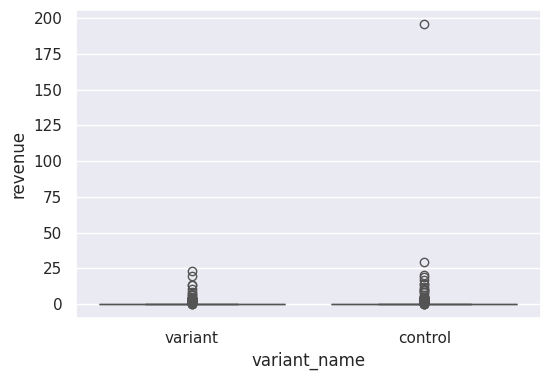

In [15]:
sns.set(rc={'figure.figsize':(6,4)}, style="darkgrid", palette="muted")
sns.boxplot(data=df, x='variant_name', y='revenue')
plt.show()

Видим один выброс. Удалим его.

In [16]:
df = df[df['revenue'] < 175]

## Разведочный анализ данных в каждой группе

In [17]:
table = df.groupby('variant_name').agg({'user_id':['count', 'nunique'],
                                        'revenue':['sum', 'mean', 'median',
                                                   ('95%', lambda x: np.percentile(x, 95)),
                                                   ('99%', lambda x: np.percentile(x, 99))]})
table

user_id         revenue                              
               count nunique     sum      mean median  95%     99%
variant_name                                                      
control         3025    2389  274.55  0.090760    0.0  0.0  2.3112
variant         3044    2393  179.32  0.058909    0.0  0.0  1.2785

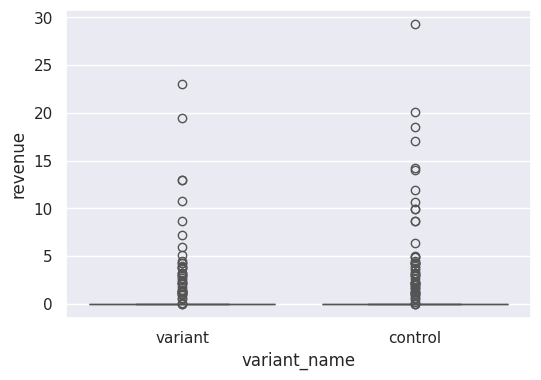

In [18]:
sns.boxplot(data=df, x='variant_name', y='revenue')
plt.show()

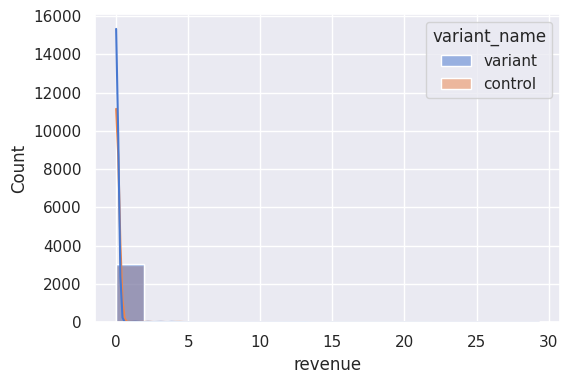

In [19]:
sns.histplot(df, x='revenue', hue='variant_name', bins=15, kde=True)
plt.show()

Посмотрим на пользователей которые хоть что-то покупали:

In [20]:
df_paying = df[df['revenue'] > 0]
table_paying = df_paying.groupby('variant_name').agg({'user_id':['count', 'nunique'],
                                                      'revenue':['sum', 'mean', 'median',
                                                                 ('95%', lambda x: np.percentile(x, 95)),
                                                                 ('99%', lambda x: np.percentile(x, 99))]})
table_paying

user_id         revenue                                  
               count nunique     sum      mean median     95%      99%
variant_name                                                          
control           53      53  274.55  5.180189   2.99  17.654  24.5100
variant           43      42  179.32  4.170233   2.72  12.990  21.5406

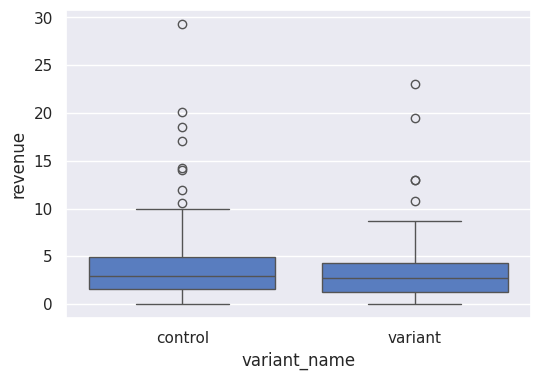

In [21]:
sns.boxplot(data=df_paying, x='variant_name', y='revenue')
plt.show()

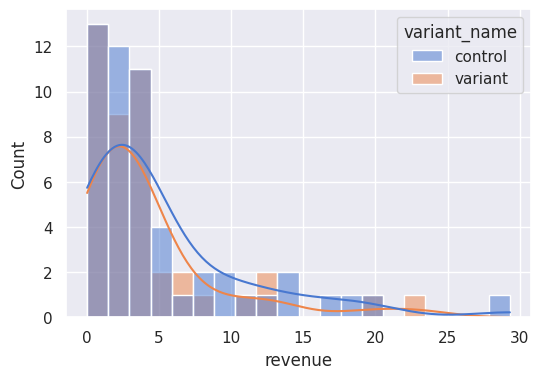

In [22]:
sns.histplot(df_paying, x='revenue', hue='variant_name', bins=20, kde=True)
plt.show()

## CR, ARPU, ARPPU

Посмотрим в каждой группе на конверсию, средний доход с одного пользователя и на средний доход с одного платящего пользователя:

In [23]:
metrics = (table_paying[('user_id', 'nunique')] / table[('user_id', 'nunique')]).to_frame(name='CR')
metrics['ARPU'] = table[('revenue', 'sum')] / table[('user_id', 'nunique')]
metrics['ARPPU'] = table[('revenue', 'sum')] / table_paying[('user_id', 'nunique')]

In [24]:
metrics.map(lambda x: f"{x:.3f}")

,CR,ARPU,ARPPU
variant_name,,,
control,0.022,0.115,5.180
variant,0.018,0.075,4.270


Все рассмотренные метрики в контрольной группе выше.

# A/B тестирование

In [25]:
data = {'control': df['revenue'][df['variant_name'] == 'control'], 'variant': df['revenue'][df['variant_name'] == 'variant']}

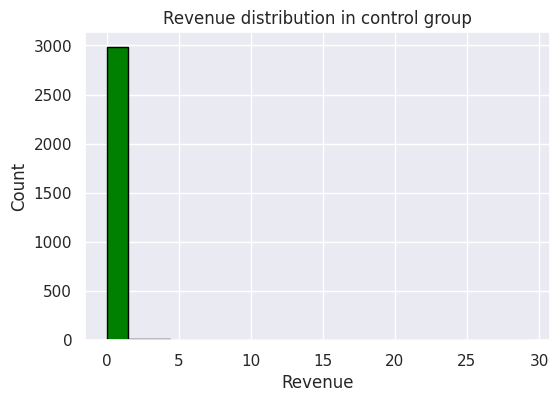

In [33]:
plt.hist(data['control'], bins=20, color='green', edgecolor='black')
plt.title('Revenue distribution in control group')
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.show()

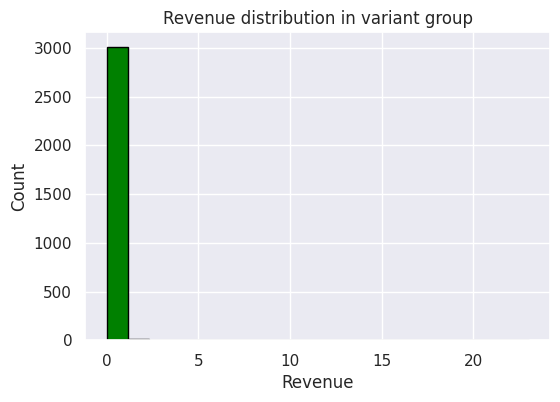

In [27]:
plt.hist(data['variant'], bins=20, color='green', edgecolor='black')
plt.title('Revenue distribution in variant group')
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.show()

По графикам уже видно, что данные в обеих группах распределены не нормально (наблюдается слишком уж ярко выраженная ассиметрия).

Убедимся в этом проверкой на нормальность с помощью критерия Шапиро-Уилка. Тогда нам необходимо проверить следующую гипотезу:

$H_0$: данные в control / variant группе имеют нормальное распределение

$H_a$: данные в control / variant группе не имеют нормальное распределение

In [28]:
for group in data:
    pvalue = stats.shapiro(data[group]).pvalue
    if pvalue > 0.05:
        print(f'{group}: p-value = {pvalue} => Гипотеза о нормальности распределения данных не отвергается на уровне значимости 0.05')
    else:
        print(f'{group}: p-value = {pvalue} => Гипотеза о нормальности распределения данных отвергается на уровне значимости 0.05')

control: p-value = 2.083866443535456e-81 => Гипотеза о нормальности распределения данных отвергается на уровне значимости 0.05
variant: p-value = 8.125449426822169e-82 => Гипотеза о нормальности распределения данных отвергается на уровне значимости 0.05


В силу слишком уж выраженной асимметрии мы не будем использовать t-критерий Стьюдента для независимых выборок, а применим критерий Манна-Уитни для проверки гипотезы о равенстве средних доходов в двух группах. Тогда гипотезы:

$H_0$: средние в control и variant группах равны

$H_a$: средние в control и variant группах не равны


In [29]:
pvalue = stats.mannwhitneyu(data['control'], data['variant']).pvalue
if pvalue > 0.05:
    print(f'p-value = {pvalue} => Гипотеза о равенстве дисперсий не отвергается на уровне значимости 0.05')
else:
    print(f'p-value = {pvalue} => Гипотеза о равенстве дисперсий отвергается на уровне значимости 0.05')

p-value = 0.2859842308619548 => Гипотеза о равенстве дисперсий не отвергается на уровне значимости 0.05


Итак, хотя и CR, и ARPU, и ARPPU были выше в контрольной группе, но проверка гипотез показала, что для имеющихся данных разница между средними доходами статистически не значима.

Хорошо бы продолжить сбор данных, так как мы наблюдали наличие огромного количества пользователей, которые принесли нам доход 0 - возможно, они сделают покупки в будущем, и это изменит итоговые выводы. Также в процессе этого стоит понять, почему вышеуказанные метрики (да и сами доходы) в группе variant ниже, чем в control.